<a href="https://colab.research.google.com/github/budvinchathura/ML-project-drivendata/blob/master/ML_project_drivendata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
from IPython.display import display, HTML   # for output formatting
from ipywidgets import widgets, Layout



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier



In [54]:
# CSS = """
# div.cell:nth-child(5) .output {
#     flex-direction: row;
# }
# """

# CSS = """
# .output {
#     flex-direction: row;
# }
# """

# HTML('<style>{}</style>'.format(CSS))

# test

In [55]:
drive.mount('/content/drive')
train_values_path = 'drive/My Drive/ML-project-drivendata/train_values.csv'
train_labels_path = 'drive/My Drive/ML-project-drivendata/train_labels.csv'
test_values_path = 'drive/My Drive/ML-project-drivendata/test_values.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
train_values_df = pd.read_csv(train_values_path)
train_labels_df = pd.read_csv(train_labels_path)

train_data_df = pd.merge(train_values_df, train_labels_df, on='id',  how='left')

test_values_df = pd.read_csv(test_values_path)

In [57]:
train_data_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


Explanation of columns

| Column      | Description |
| ----------- | ----------- |
| id      | unique id       |*italicized text*
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data |
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed |
| extraction_type | The kind of extraction the waterpoint uses |
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses |
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | working condition (label) <br/> functional / non functional / functional needs repair |

In [58]:
# output = train_data_df.info()._repr_html_() + test_values_df.info()._repr_html_()
# display(HTML(output))

# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    # display.display(df1.style.set_caption('First dataframe'))
    train_data_df.info()
with widget2:
    # display.display(df2.style.set_caption('Second dataframe'))
    test_values_df.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    
# create Horisontal Box container
hbox = widgets.HBox([widget1, widget2], layout=box_layout)

# render hbox
hbox


In [59]:
print('Zero values of each column in train data\n')
print(train_data_df.apply(lambda col: (col == 0).sum()))

Zero values of each column in train data

id                           1
amount_tsh               41639
date_recorded                0
funder                       0
gps_height               20438
installer                    0
longitude                 1812
latitude                     0
wpt_name                     0
num_private              58643
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code               23
lga                          0
ward                         0
population               21381
public_meeting            5055
recorded_by                  0
scheme_management            0
scheme_name                  0
permit                   17492
construction_year        20709
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                

In [60]:
print('Unique values of each column in train data\n')
print(train_data_df.apply(lambda col: col.nunique()))

Unique values of each column in train data

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type              

Following columns were removed from the analysis due to several reasons

| Removed Column | Reason|
|----| --------|
| amount_tsh | too many zero values (41639) |
| gps_height | too many zero values (20438) |
| wpt_name | too many unique values (this is a name column) |
| subvillage | too many unique |
| region | already encoded in region_code|
| recorded_by | only one value |
| scheme_name | too many unique values, too many missing values |
| construction_year | too many zero values (20709) |



In [61]:
def drop_unwanted_columns(df):
    # selected_columns = ['id',
    # 'date_recorded',
    # 'funder',
    # 'installer',
    # 'longitude',
    # 'latitude',
    # 'num_private',
    # 'basin',
    # 'region_code',
    # 'district_code',
    # 'lga',
    # 'ward',
    # 'population',
    # 'public_meeting',
    # 'scheme_management',
    # 'permit',
    # 'extraction_type',
    # 'extraction_type_group',
    # 'extraction_type_class',
    # 'management',
    # 'management_group',
    # 'payment',
    # 'payment_type',
    # 'water_quality',
    # 'quality_group',
    # 'quantity',
    # 'quantity_group',
    # 'source',
    # 'source_type',
    # 'source_class',
    # 'waterpoint_type',
    # 'waterpoint_type_group',
    # 'status_group']
    unwanted_columns = [
                        # 'amount_tsh',
                        # 'gps_height',	
                        'wpt_name',	
                        'subvillage',	
                        'region',	
                        'recorded_by',	
                        'scheme_name',	
                        'construction_year'	
                        ]

    return df.drop(unwanted_columns, axis=1, inplace=False)
  
train_data_df = drop_unwanted_columns(train_data_df)
test_values_df = drop_unwanted_columns(test_values_df)


In [62]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  region_code            59400 non-null  int64  
 11  district_code          59400 non-null  int64  
 12  lga                    59400 non-null  object 
 13  ward                   59400 non-null  object 
 14  population             59400 non-null  int64  
 15  pu

In [63]:
print('Zero values of each column')
print(train_data_df.apply(lambda col: (col == 0).sum()))

Zero values of each column
id                           1
amount_tsh               41639
date_recorded                0
funder                       0
gps_height               20438
installer                    0
longitude                 1812
latitude                     0
num_private              58643
basin                        0
region_code                  0
district_code               23
lga                          0
ward                         0
population               21381
public_meeting            5055
scheme_management            0
permit                   17492
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class

In [64]:
print('Unique values of each column')
print(train_data_df.apply(lambda col: col.nunique()))

Unique values of each column
id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
num_private                 65
basin                        9
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
scheme_management           12
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_cla

In [65]:
# helper function to plot heatmaps
def plot_heatmap(dataframe, first_column, second_column):
    pivot_table = dataframe.pivot_table('id',first_column,second_column,aggfunc='count').fillna(0).astype(int)
    sns.heatmap(pivot_table, annot=True, fmt="d")

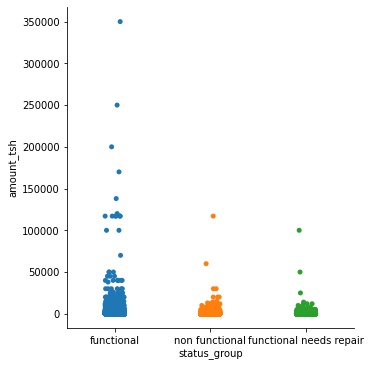

In [66]:
sns.catplot(x="status_group", y="amount_tsh", data=train_data_df)

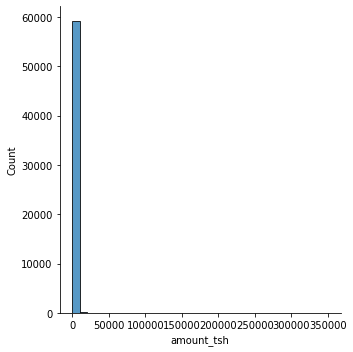

In [67]:
sns.displot(train_data_df, x="amount_tsh",binwidth=10000)

With above 2 graphs it is clear that `amount_tsh` column is too skewed towards 0 values and if does not give a much contribution to differentiate the target column categories. Because of that can drop `amount_tsh` column

In [68]:
train_data_df.drop('amount_tsh', axis=1, inplace=True)
test_values_df.drop('amount_tsh', axis=1, inplace=True)

We can transform `recorded_date` date type column to an integer column by encoding it as a relative date. In this scenario I have decided to take the earliest recorded date as a reference date (=0) and mark all others with relative dates.

In [69]:
# encoding recorded_date column as a relative date

def encode__date_recorded(df, reference_date):
    df['date_recorded__relative'] = df.apply(lambda row: int((row.date_recorded - reference_date).days), axis=1)

    # drop original date column
    return df.drop('date_recorded', axis=1, inplace=False)

# change data type to date
train_data_df['date_recorded'] = pd.to_datetime(train_data_df["date_recorded"])
test_values_df['date_recorded'] = pd.to_datetime(test_values_df["date_recorded"])

earliest_date = train_data_df['date_recorded'].min()

train_data_df = encode__date_recorded(train_data_df, earliest_date)
test_values_df = encode__date_recorded(test_values_df, earliest_date)


`funder` and `installer` columns have a significant cardinality. To get a better reduced encoding, I have combined those two columns and applied frequency encoding for the combined column.

In [70]:

# combine funder and installer and then frequency encode them
def encode_funder_installer(df, freq):

    df['funder_installer__freq'] = df['funder_installer'].apply(lambda x : freq[x] if freq.index.isin([x]).any() else 0)
    # print(df[['funder','installer','funder_installer','funder_installer__freq']].head(10))
    return df.drop(['funder','installer','funder_installer'], axis=1, inplace=False)

train_data_df['funder_installer'] = train_data_df.apply(lambda row: str(row.funder) + str(row.installer), axis=1)
test_values_df['funder_installer'] = test_values_df.apply(lambda row: str(row.funder) + str(row.installer), axis=1)

frequencies = (train_data_df.groupby('funder_installer').size()) / len(train_data_df)
# print(frequencies)

train_data_df = encode_funder_installer(train_data_df, frequencies)
test_values_df = encode_funder_installer(test_values_df, frequencies)

`gps_height` column has significant number of 0 values but, with following graphs it is evident that gps height has a correlation with the target column, where **higher gps height tends to infer that probably it is a functional pump**. To remove all 0 values, I filled those with the average gps height (elevation) of Tanzania. Source : https://en.wikipedia.org/wiki/List_of_countries_by_average_elevation

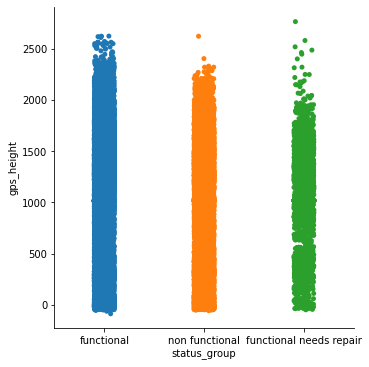

In [71]:
def encode_gps_height(df):
    df['gps_height'] = df['gps_height'].replace([0],1018)     # avg elevantion in Tanzania https://en.wikipedia.org/wiki/List_of_countries_by_average_elevation
    return df

train_data_df = encode_gps_height(train_data_df)
test_values_df = encode_gps_height(test_values_df) 

sns.catplot(x="status_group", y="gps_height", data=train_data_df)

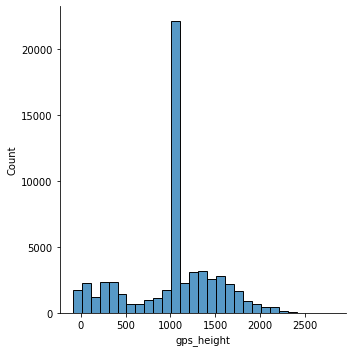

In [72]:
sns.displot(train_data_df, x="gps_height",binwidth=100)

When it comes to location data, some records have invalid values for longitude and latitude columns. Those missing values should be filled. Filling those with average values is not that efficient since we can do better with other labels like region, district code, subvillage and ward. After doing some analysis I found that `district_code` can be used to fill missing values in `longitude` and `latitude` columns. Specifically we can group records by `district_code`, find the mean gps coordinated of each district and use that to fill invalid gps coordinates. Here I used district code since it is the most granular level of detail I could find related to location data. Subvillage is more specific by, I observed that, when there are invalid gps coordinates, all records with that same subvillage of that records, have invalid gps coordinates. So subvillage can not be used for this.

In [73]:

# There are some invalid values for lat and long
# We can fill a guessed value by approximating from the repsective district code
# For that I have calculated the avg lat, long for each district code


def fill_missing_lat_long(df, mean_long, mean_lat):
    for idx, row in df.iterrows():
        if df.loc[idx,'longitude'] == 0:
            df.loc[idx,'longitude'] = mean_long[df.loc[idx,'district_code']]
            df.loc[idx,'latitude'] = mean_lat[df.loc[idx,'district_code']]
    return df

mean_long_by_DC = train_data_df.loc[train_data_df['longitude'] != 0].groupby(['district_code'])['longitude'].mean()
mean_lat_by_DC = train_data_df.loc[train_data_df['longitude'] != 0].groupby(['district_code'])['latitude'].mean()

train_data_df = fill_missing_lat_long(train_data_df, mean_long_by_DC, mean_lat_by_DC)
test_values_df = fill_missing_lat_long(test_values_df, mean_long_by_DC, mean_lat_by_DC)


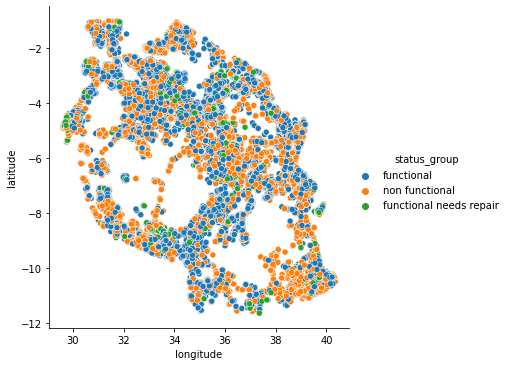

In [74]:

sns.relplot(x="longitude", y="latitude", hue="status_group", data=train_data_df)

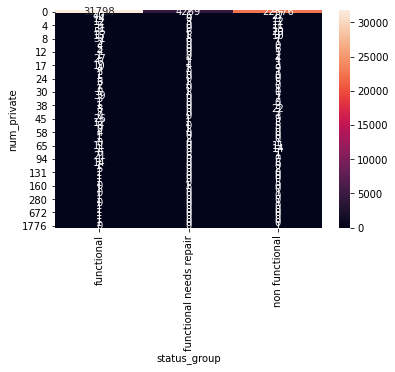

In [75]:
plot_heatmap(train_data_df, 'num_private','status_group')

There are too many 0 values in `num_private` column. Other non zero values also do not provide a significant contribution to distinguish the target categories. We can drop this column.

In [76]:
train_data_df.drop(['num_private'], axis=1, inplace=True)
test_values_df.drop(['num_private'], axis=1, inplace=True)

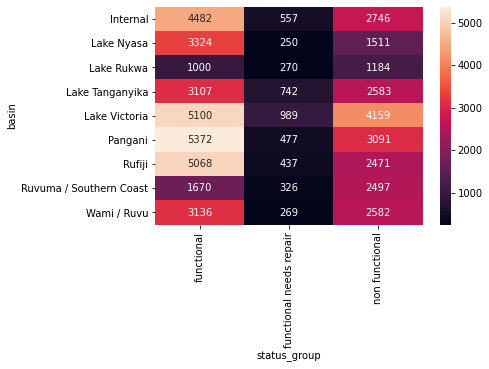

In [77]:

plot_heatmap(train_data_df, 'basin','status_group')

`basin` column has a good distribution and since it has only 9 different values, it is a good candidate for one hot encoding.

In [78]:
# one hot encode 'basin' column

def encode_basin(df):
    return pd.get_dummies(df,prefix=['basin'], columns = ['basin'], drop_first=False)

train_data_df = encode_basin(train_data_df)
test_values_df = encode_basin(test_values_df)

In [79]:
# these are now probably redundant since we have exact coordinates
def drop_other_location_data(df):
    return df.drop(['lga', 'ward'], axis=1, inplace=False)

train_data_df = drop_other_location_data(train_data_df)
test_values_df = drop_other_location_data(test_values_df)

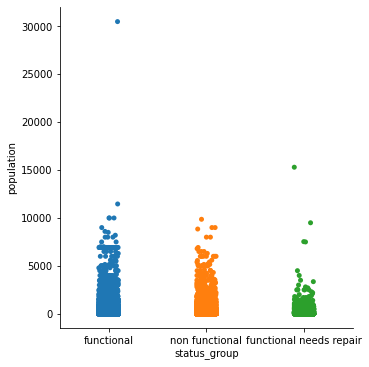

In [80]:
sns.catplot(x="status_group", y="population", data=train_data_df)

With aboce graph we can see that population has some correlation with the target column. Repairing needed pumps tends to be situated in areas where there is less population. We can investiage this column further by analyzing its distribution.

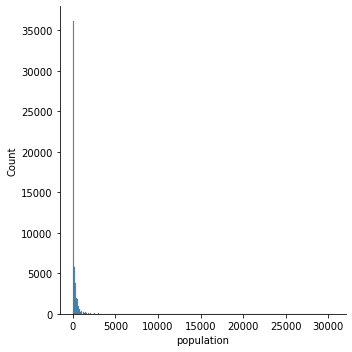

In [81]:
sns.displot(train_data_df, x="population",binwidth=100)

As the above graph suggests, population column distribution has a long tail. To minimize this effect, we can log10 transform the column and get a better distribution. There are many records with 0 values but still this column has a significant correlation with taget column. We will keep those 0 values as it is.

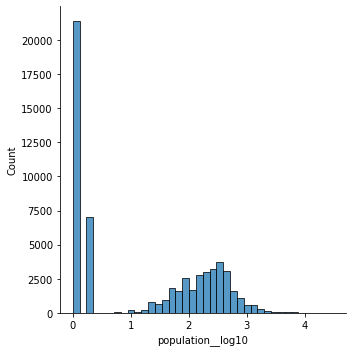

In [82]:
# log10 transform population column

def log10_transform_population(df):
    df['population'] = df['population'].apply(lambda x: x + 1)    # to avoid errors in log function
    df['population__log10'] = np.log10(df['population'])
    return df.drop('population', axis=1, inplace=False)

train_data_df = log10_transform_population(train_data_df)
test_values_df = log10_transform_population(test_values_df)
sns.displot(train_data_df, x="population__log10")

`public_meeting` column was re-encoded so that missing values will also have a meaning.

Encoding is as follows

True -> 1

False -> -1

Missing -> 0

In [83]:
# re-encode public_meeting column
# True ->1
# False -> -1
# Missing -> 0

def encode_public_meeting(df):
    df["public_meeting"] = df["public_meeting"].astype('float')
    df['public_meeting'] = df['public_meeting'].apply(lambda x: -1 if x==0 else (x if x==1 else 0)) 
    return df

train_data_df = encode_public_meeting(train_data_df)
test_values_df = encode_public_meeting(test_values_df)


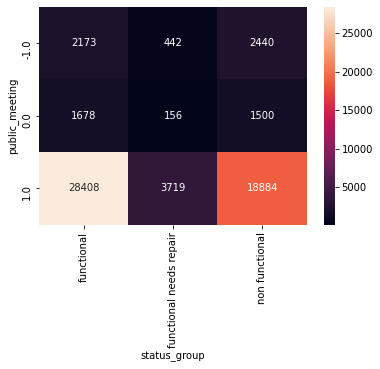

In [84]:

plot_heatmap(train_data_df, 'public_meeting','status_group')

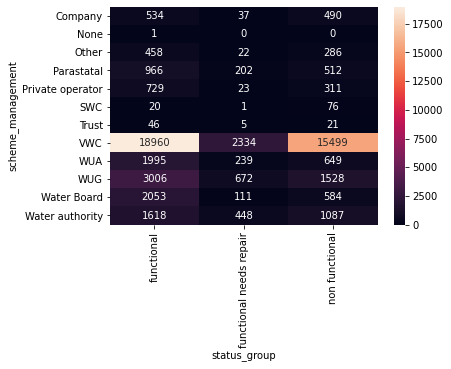

In [85]:
plot_heatmap(train_data_df, 'scheme_management','status_group')

In [86]:
# scheme_management is too skewed towards VWC value
# we can drop it

train_data_df.drop('scheme_management', axis=1, inplace=True)
test_values_df.drop('scheme_management', axis=1, inplace=True)

We will re-encode `permit` column as same as `public_meeting` column where the missing values will also have a meaning.

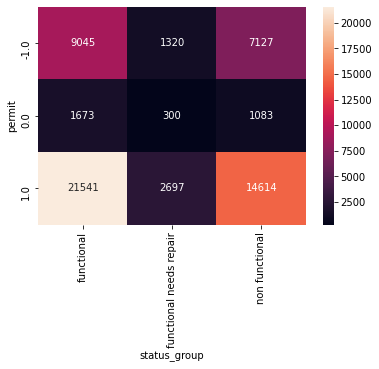

In [87]:
# encode permit column same as public_meeting column

def encode_permit(df):
    df["permit"] = df["permit"].astype('float')
    df['permit'] = df['permit'].apply(lambda x: -1 if x==0 else (x if x==1 else 0)) 
    return df

train_data_df = encode_permit(train_data_df)
test_values_df = encode_permit(test_values_df)


plot_heatmap(train_data_df, 'permit','status_group')

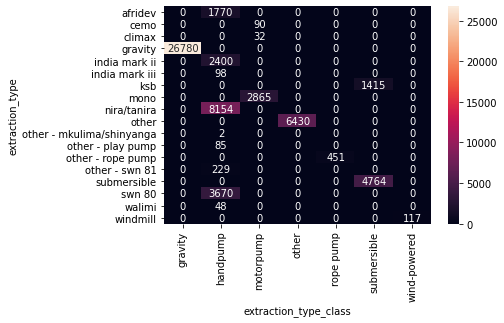

In [88]:
plot_heatmap(train_data_df, 'extraction_type','extraction_type_class')


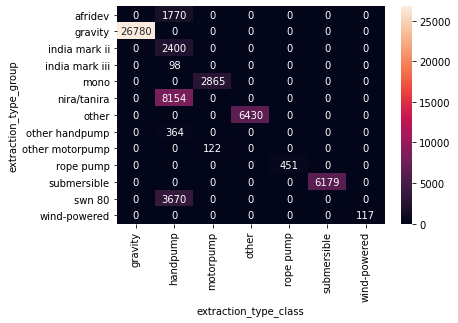

In [89]:
plot_heatmap(train_data_df, 'extraction_type_group','extraction_type_class')


From above graphs we can see that `extraction_type_class` captures the same information as `extraction_type` and `extraction_type_group`. Also `extraction_type_class` has a low cardinality. We can keep `extraction_type_class`, one hot encode it and drop other two columns.

In [90]:

def encode_extraction_data(df):
    df.drop('extraction_type', axis=1, inplace=True)
    df.drop('extraction_type_group', axis=1, inplace=True)

    return pd.get_dummies(df,prefix=['extraction_type_class'], columns = ['extraction_type_class'], drop_first=False)

train_data_df = encode_extraction_data(train_data_df)
test_values_df = encode_extraction_data(test_values_df)

train_data_df.head()

,id,gps_height,longitude,latitude,region_code,district_code,public_meeting,permit,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
0,69572,1390,34.938093,-9.856322,11,5,1.0,-1.0,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0
1,8776,1399,34.698766,-2.147466,20,2,0.0,1.0,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0
2,34310,686,37.460664,-3.821329,21,4,1.0,1.0,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0
3,67743,263,38.486161,-11.155298,90,63,1.0,1.0,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0
4,19728,1018,31.130847,-1.825359,18,1,1.0,1.0,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0


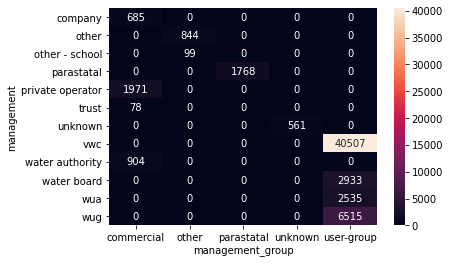

In [91]:
plot_heatmap(train_data_df, 'management','management_group')


Same method can be applied to `management` and `management_group` columns. We can keep `management_group` column and discard the other.

In [92]:

def encode_management_data(df):
    df.drop('management', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['management_group'], columns = ['management_group'], drop_first=False)

train_data_df = encode_management_data(train_data_df)
test_values_df = encode_management_data(test_values_df)

train_data_df.head()

,id,gps_height,longitude,latitude,region_code,district_code,public_meeting,permit,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group
0,69572,1390,34.938093,-9.856322,11,5,1.0,-1.0,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1
1,8776,1399,34.698766,-2.147466,20,2,0.0,1.0,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1
2,34310,686,37.460664,-3.821329,21,4,1.0,1.0,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1
3,67743,263,38.486161,-11.155298,90,63,1.0,1.0,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1
4,19728,1018,31.130847,-1.825359,18,1,1.0,1.0,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0


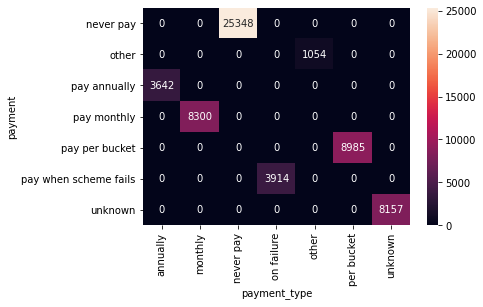

In [93]:
plot_heatmap(train_data_df, 'payment','payment_type')

Same method for `payment` and `payment_type` columns.

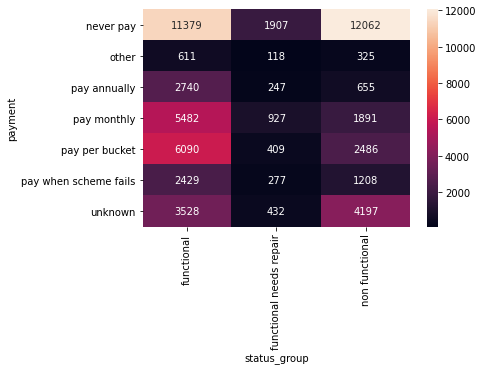

In [94]:
plot_heatmap(train_data_df, 'payment','status_group')

In [95]:

def encode_payment_data(df):
    df.drop('payment_type', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['payment'], columns = ['payment'], drop_first=False)

train_data_df = encode_payment_data(train_data_df)
test_values_df = encode_payment_data(test_values_df)

train_data_df.head()

,id,gps_height,longitude,latitude,region_code,district_code,public_meeting,permit,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown
0,69572,1390,34.938093,-9.856322,11,5,1.0,-1.0,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,8776,1399,34.698766,-2.147466,20,2,0.0,1.0,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,34310,686,37.460664,-3.821329,21,4,1.0,1.0,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,67743,263,38.486161,-11.155298,90,63,1.0,1.0,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
4,19728,1018,31.130847,-1.825359,18,1,1.0,1.0,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


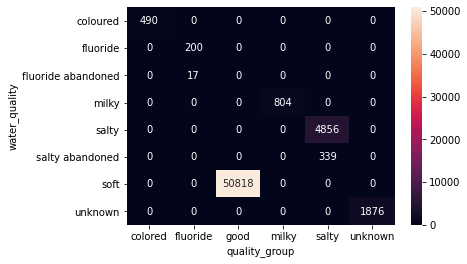

In [96]:

plot_heatmap(train_data_df, 'water_quality','quality_group')

Same method for `water_quality` and `quality_group` columns.

In [97]:

def encode_water_quality(df):
  df.drop('water_quality', axis=1, inplace=True)
  return pd.get_dummies(df,prefix=['quality_group'], columns = ['quality_group'], drop_first=False)

train_data_df = encode_water_quality(train_data_df)
test_values_df = encode_water_quality(test_values_df)
train_data_df.head()

,id,gps_height,longitude,latitude,region_code,district_code,public_meeting,permit,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown
0,69572,1390,34.938093,-9.856322,11,5,1.0,-1.0,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
1,8776,1399,34.698766,-2.147466,20,2,0.0,1.0,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
2,34310,686,37.460664,-3.821329,21,4,1.0,1.0,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,67743,263,38.486161,-11.155298,90,63,1.0,1.0,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
4,19728,1018,31.130847,-1.825359,18,1,1.0,1.0,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


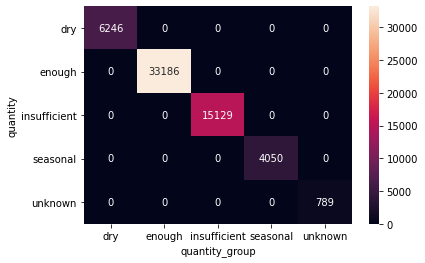

In [98]:
plot_heatmap(train_data_df, 'quantity','quantity_group')

Same method for `quantity` and `quantity_group` columns.**bold text**

In [99]:
def encode_quantity(df):
    df.drop('quantity_group', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['quantity'], columns = ['quantity'], drop_first=False)

train_data_df = encode_quantity(train_data_df)
test_values_df = encode_quantity(test_values_df)

train_data_df.head()

,id,gps_height,longitude,latitude,region_code,district_code,public_meeting,permit,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown
0,69572,1390,34.938093,-9.856322,11,5,1.0,-1.0,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,8776,1399,34.698766,-2.147466,20,2,0.0,1.0,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,34310,686,37.460664,-3.821329,21,4,1.0,1.0,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,67743,263,38.486161,-11.155298,90,63,1.0,1.0,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,19728,1018,31.130847,-1.825359,18,1,1.0,1.0,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


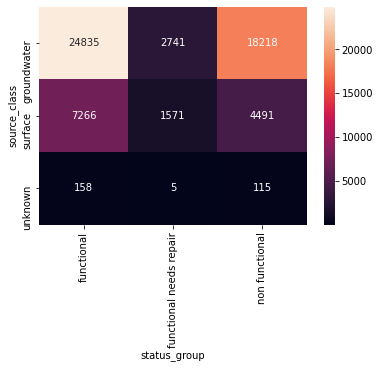

In [100]:
plot_heatmap(train_data_df,'source_class', 'status_group')

In [101]:

def encode_source(df):
    df.drop('source', axis=1, inplace=True)
    df.drop('source_type', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['source_class'], columns = ['source_class'], drop_first=False)

train_data_df = encode_source(train_data_df)
test_values_df = encode_source(test_values_df)

train_data_df.head()

,id,gps_height,longitude,latitude,region_code,district_code,public_meeting,permit,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_class_groundwater,source_class_surface,source_class_unknown
0,69572,1390,34.938093,-9.856322,11,5,1.0,-1.0,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
1,8776,1399,34.698766,-2.147466,20,2,0.0,1.0,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,34310,686,37.460664,-3.821329,21,4,1.0,1.0,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,67743,263,38.486161,-11.155298,90,63,1.0,1.0,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,19728,1018,31.130847,-1.825359,18,1,1.0,1.0,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


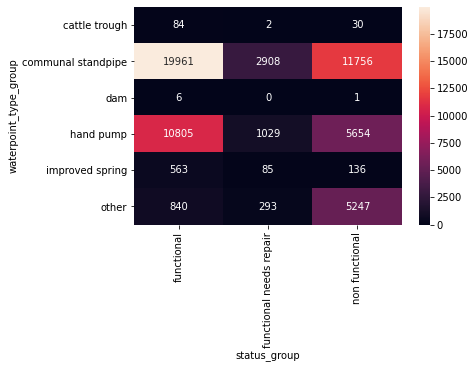

In [102]:
plot_heatmap(train_data_df,'waterpoint_type_group', 'status_group')

In [103]:
def encode_waterpoint(df):
    df.drop('waterpoint_type', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['waterpoint_type_group'], columns = ['waterpoint_type_group'], drop_first=False)

train_data_df = encode_waterpoint(train_data_df)
test_values_df = encode_waterpoint(test_values_df)

train_data_df.head()

,id,gps_height,longitude,latitude,region_code,district_code,public_meeting,permit,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,1390,34.938093,-9.856322,11,5,1.0,-1.0,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,8776,1399,34.698766,-2.147466,20,2,0.0,1.0,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,34310,686,37.460664,-3.821329,21,4,1.0,1.0,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,67743,263,38.486161,-11.155298,90,63,1.0,1.0,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,19728,1018,31.130847,-1.825359,18,1,1.0,1.0,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [104]:
status_group_encoded = pd.factorize(train_data_df['status_group'])
train_data_df.status_group = status_group_encoded[0]


In [105]:
train_data_df.head()

,id,gps_height,longitude,latitude,region_code,district_code,public_meeting,permit,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,1390,34.938093,-9.856322,11,5,1.0,-1.0,0,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,8776,1399,34.698766,-2.147466,20,2,0.0,1.0,0,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,34310,686,37.460664,-3.821329,21,4,1.0,1.0,0,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,67743,263,38.486161,-11.155298,90,63,1.0,1.0,1,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,19728,1018,31.130847,-1.825359,18,1,1.0,1.0,0,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


Now we have the cleaned and processed dataset. We can split into training and validation sets and run different models to choose which model is the best to this case

In [106]:

y = train_data_df['status_group']
X = train_data_df.drop(['id','status_group'], axis=1)

test_data_ids = test_values_df['id']
test_data_df = test_values_df.drop('id', axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.25, random_state = 5, stratify=y)


In [107]:
def plot_importances(classif, x_df):
    importances = classif.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 14)
    ax.barh(range(len(importances)), importances[indices])
    ax.set_yticks(range(len(importances)))
    _ = ax.set_yticklabels(np.array(x_df.columns)[indices])

# Grid Search

In [108]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True, False],
#     'max_depth': [80, 90, 100, 110, None],
#     'max_features': ['auto', 'log2', None],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# grid_search_classifier = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = RandomizedSearchCV(estimator = grid_search_classifier, param_distributions  = param_grid, n_iter = 5,
#                           cv = 5, n_jobs = -1, verbose = 2)
# grid_search.fit(train_data_df.drop(['id','status_group'], axis=1), train_data_df['status_group'])


In [109]:
# print(grid_search.best_params_)

# best_grid = grid_search.best_estimator_
# print(f'TRAIN ACCURACY OF THE best grid search MODEL:  {best_grid.score(train_data_df.drop(['id','status_group'], axis=1), train_data_df['status_group'])}')


# Single Random Forest

In [110]:
# classifier = RandomForestClassifier(n_estimators = 1000, random_state = 6, min_samples_leaf=3)
# classifier.fit(X_train, y_train)


In [111]:
# print(f'TRAIN ACCURACY OF THE MODEL:  {classifier.score(X_train, y_train)}')
# y_validation_pred = classifier.predict(X_validation)

# print(f'Validation Accuracy: {accuracy_score(y_validation, y_validation_pred)}')

# print('Report for Validation Data: ')
# print(classification_report(y_validation, y_validation_pred))

### Train a new classifier again with full dataset to predict test dataset

In [112]:
# new_classifier = RandomForestClassifier(n_estimators = 1000, random_state = 6, min_samples_leaf=3)
# new_classifier.fit(X, y)

# test_data_pred = new_classifier.predict(test_data_df)
# test_result = pd.concat([test_data_ids, pd.DataFrame(test_data_pred)], axis=1)
# # test_data_pred
# test_result.columns = ['id', 'status_group']
# test_result['status_group'] = test_result['status_group'].apply(lambda x: 'functional' if x==0 else ('non functional' if x==1 else 'functional needs repair'))
# test_result.to_csv('submission.csv', sep=',', index=False)

# XGBoost

In [115]:
classifier = XGBClassifier(n_estimators=850,subsample=0.8, use_label_encoder=False, random_state = 6, max_depth=9, learning_rate=0.04, verbosity=1)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.04, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=850, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=6,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, use_label_encoder=False, verbosity=1)

In [116]:
print(f'TRAIN ACCURACY OF THE MODEL:  {classifier.score(X_train, y_train)}')
y_validation_pred = classifier.predict(X_validation)

print(f'Validation Accuracy: {accuracy_score(y_validation, y_validation_pred)}')

print('Accuracy for Validation Data: ')
print(classification_report(y_validation, y_validation_pred))

TRAIN ACCURACY OF THE MODEL:  0.9330190796857464
Validation Accuracy: 0.8052525252525252
Accuracy for Validation Data: 
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      8065
           1       0.84      0.76      0.80      5706
           2       0.58      0.32      0.41      1079

    accuracy                           0.81     14850
   macro avg       0.74      0.66      0.69     14850
weighted avg       0.80      0.81      0.80     14850



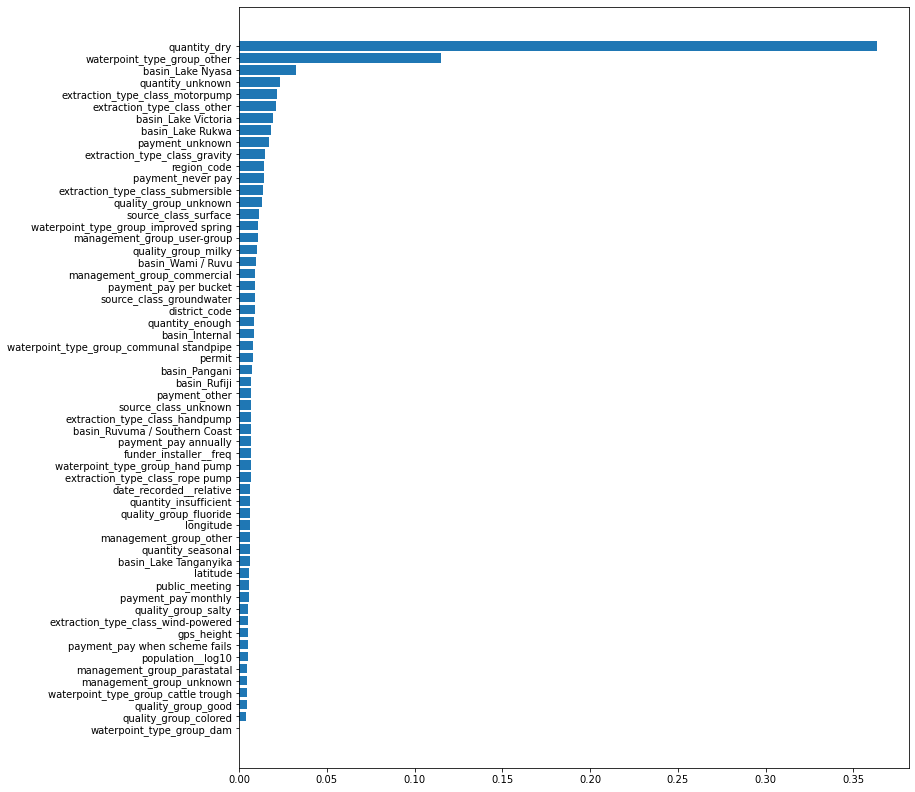

In [117]:
plot_importances(classifier, X_train)

### Train a new classifier again with full dataset to predict test dataset

In [118]:
new_classifier = XGBClassifier(n_estimators=850,subsample=0.8, use_label_encoder=False, random_state = 6, max_depth=9, learning_rate=0.04, verbosity=1)
new_classifier.fit(X, y)

test_data_pred = new_classifier.predict(test_data_df)
test_result = pd.concat([test_data_ids, pd.DataFrame(test_data_pred)], axis=1)
test_result.columns = ['id', 'status_group']
test_result['status_group'] = test_result['status_group'].apply(lambda x: 'functional' if x==0 else ('non functional' if x==1 else 'functional needs repair'))
test_result.to_csv('submission.csv', sep=',', index=False)

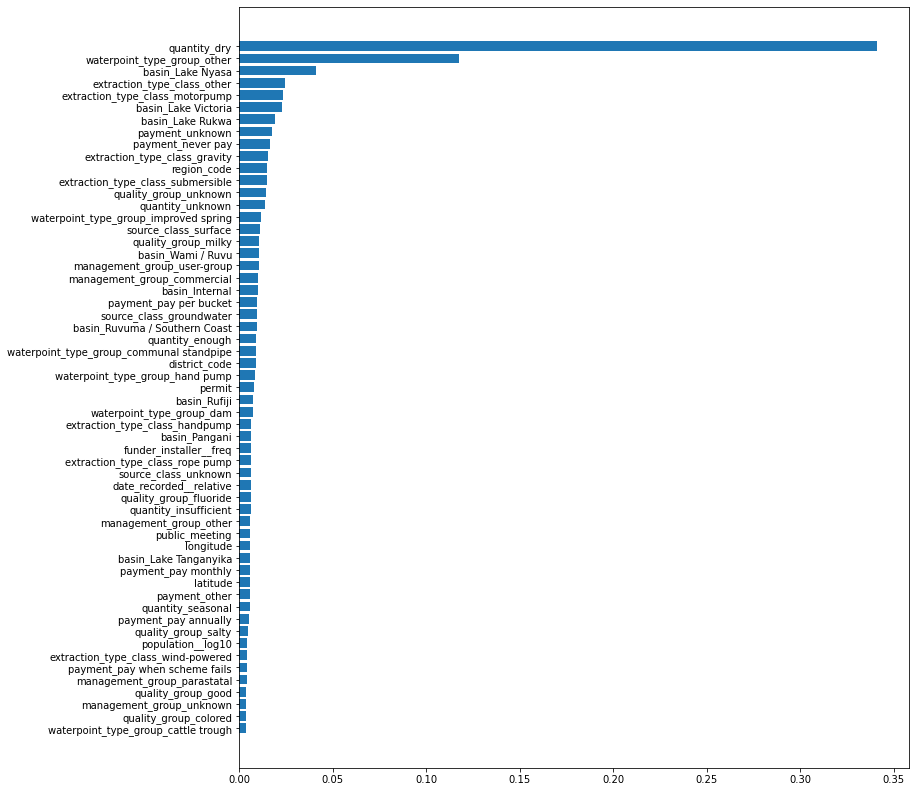

In [ ]:
plot_importances(new_classifier, X)

# Other Stuff

In [ ]:

# one hot encode 'scheme_management' column

# train_data_df = pd.get_dummies(train_data_df,prefix=['basin'], columns = ['basin'], drop_first=False)

In [ ]:
# train_data_df.loc[train_data_df['longitude'] == 0]

In [ ]:
# test_values_df.info()
# print(test_values_df.apply(lambda col: (col == 0).sum()))

In [ ]:
# sns.countplot(x="status_group", data=train_data_df.loc[train_data_df['longitude'] == 0])

In [ ]:
# train_data_df['log10_amount_tsh'] = np.log10(train_data_df['amount_tsh'])
# sns.catplot(x="status_group", y="log10_amount_tsh", data=train_data_df)

In [ ]:
# train_data_df['construction_year'].value_counts()
# filtered = train_data_df.loc[train_data_df['construction_year'] > 0]
# sns.catplot(x="status_group", y="construction_year", data=filtered)

In [ ]:
# filtered = train_data_df.loc[train_data_df['longitude'] > 0]
# sns.relplot(x="longitude", y="latitude", hue="status_group", data=filtered)


In [ ]:
# pivot_table = train_data_df.pivot_table('id','waterpoint_type','status_group',aggfunc='count').fillna(0).astype(int)
# sns.heatmap(pivot_table)
